In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
df = pd.read_csv("all_stocks_5yr.csv")
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [4]:
def information(df):
    display(df.info())
    display(df.isnull().sum())
    display(df.describe())
information(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


None

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


**Processing data**

In [5]:
def retime(data):
    df = data.copy()
    df['date'] = pd.to_datetime(df['date'])  
    df['year'] = df['date'].dt.year  
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df = df.drop(columns="date", errors='ignore') 
    return df
def plot_features(df, feature_names, plot_type='distplot'):
    num_features = len(feature_names)
    grid_size = (2, 3)
    num_rows = (num_features - 1) // grid_size[1] + 1
    num_cols = min(num_features, grid_size[1])
    plt.figure(figsize=(15, 5 * num_rows))

    for i, col in enumerate(feature_names, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.violinplot(x=col, data=df)
        plt.title(f"{plot_type.capitalize()} of {col}", fontsize=14)
        plt.xlabel(col, fontsize=12)

    plt.tight_layout()
    plt.show()
# Determine Outliers range
def find_outliers(df, feature_names):
    data = df.copy()
    for feature_name in feature_names:
        z_scores = np.abs(stats.zscore(data[feature_name]))
        threshold = 3
        data = data[(z_scores < threshold)]
    return data
# Delete defined Outliers values
def remove_outliers(df, feature_names):
    data = df.copy()
    data = find_outliers(data, feature_names)
    return data
def Encoder_column(data):
    label_encoder = LabelEncoder()
    df=data.copy()
    object_columns = ['Name']
    for col in object_columns:
        df[col] = label_encoder.fit_transform(df[col])    
    return df


In [6]:
def Processing(data):
    df = data.copy()
    df= df.dropna()
    df = retime(df)
    COL = df.drop(columns=['Name', 'year', 'month', 'day'])
    COL = COL.columns
    #display(plot_features(df, COL))
    out_series = COL
    df= remove_outliers(df, out_series)
    df = Encoder_column(df)
    return df

In [7]:
data = Processing(df)
data.head()

,open,high,low,close,volume,Name,year,month,day
0,15.07,15.12,14.63,14.75,8407500,1,2013,2,8
1,14.89,15.01,14.26,14.46,8882000,1,2013,2,11
2,14.45,14.51,14.10,14.27,8126000,1,2013,2,12
3,14.30,14.94,14.25,14.66,10259500,1,2013,2,13
5,13.93,14.61,13.93,14.50,15628000,1,2013,2,15


In [71]:
def split_data(data, column):
    df = data.copy()
    X = df.drop(columns=[column]).values
    y = df[column].values
    
    # Chia dữ liệu thành tập huấn luyện và tập kiểm thử
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)
    
    # Tạo tập validation từ tập huấn luyện
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2023)  # Giả sử 10% tập huấn luyện làm tập validation
    
    # Chuẩn hóa dữ liệu
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)  # Chuẩn hóa tập validation bằng cùng scaler
    
    return X_train_scaled, X_test_scaled, X_val_scaled, y_train, y_test, y_val
    
def evaluate_regression_model(x_train, x_test, y_train, y_test,model):
    #X_train = x_train[:, :-1]
    #print(len(X_train[0]))
    #X_test = x_test[:, :-1]
    X_train = x_train
    #print(len(X_train[0]))
    X_test = x_test
    pipeline = make_imb_pipeline(
        model
    )

    model = pipeline.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    # Tính toán và in ra MSE và RMSE cho tập kiểm tra và huấn luyện
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    
    rmse_test = np.sqrt(mse_test)
    rmse_train = np.sqrt(mse_train)
    
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    # Tính toán và in ra R^2 cho tập kiểm tra và huấn luyện
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    # In kết quả
    dt= {
    "Metric": ["Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "Mean Absolute Error (MAE)","R² Score"],
    "Test Set": [mse_test, rmse_test,mae_test, r2_test],
    "Train Set": [mse_train, rmse_train,mae_train, r2_train]
    }
    dt = pd.DataFrame(dt)
    results_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
    results_train = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train })
    results_test = pd.DataFrame({
        'Actual': y_test, 
        'Predicted':  y_pred_test
    })

    results_train = pd.DataFrame({
        'Actual': y_train, 
        'Predicted':  y_pred_train
    })
    #pd.options.display.float_format = None
    return results_test,results_train ,dt,model

def Model_Linear(data,column):
    df=data.copy()
    X_train, X_test,X_val, y_train, y_test,y_val = split_data(data,column)
    retest_LR,retrain_LR,d_LR,model = evaluate_regression_model(X_train, X_test, y_train, y_test,model = LinearRegression())
    print("result model")
    display(d_LR)
    print("result test predict")
    display(retest_LR)
    print("result train predict")
    display(retrain_LR)
    return retest_LR,retrain_LR,d_LR,model ,X_val,y_val
    

In [72]:
retest_LR,retrain_LR,d_LR,model,X_val,y_val = Model_Linear(data,column='close')
    

result model


,Metric,Test Set,Train Set
0,Mean Squared Error (MSE),0.175523,0.177301
1,Root Mean Squared Error (RMSE),0.418955,0.421072
2,Mean Absolute Error (MAE),0.272748,0.273416
3,R² Score,0.999870,0.999869


result test predict


,Actual,Predicted
0,35.59,35.477896
1,92.50,93.282254
2,152.24,152.060973
3,100.83,101.818688
4,78.11,77.290349
...,...,...
172518,79.51,79.211699
172519,81.10,81.340342
172520,105.40,104.802511
172521,17.49,17.311350


result train predict


,Actual,Predicted
0,66.970,67.209748
1,31.750,31.535569
2,66.215,65.926952
3,58.000,57.986347
4,107.420,107.179637
...,...,...
362291,86.010,85.720199
362292,98.670,98.782144
362293,38.660,38.304695
362294,60.580,61.531504


In [79]:

def scatter_pred(results_val):
    actual = results_val.Actual
    predicted = results_val.Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
    #plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Line')
    plt.plot(actual, actual, color='red', label='Perfect Line')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

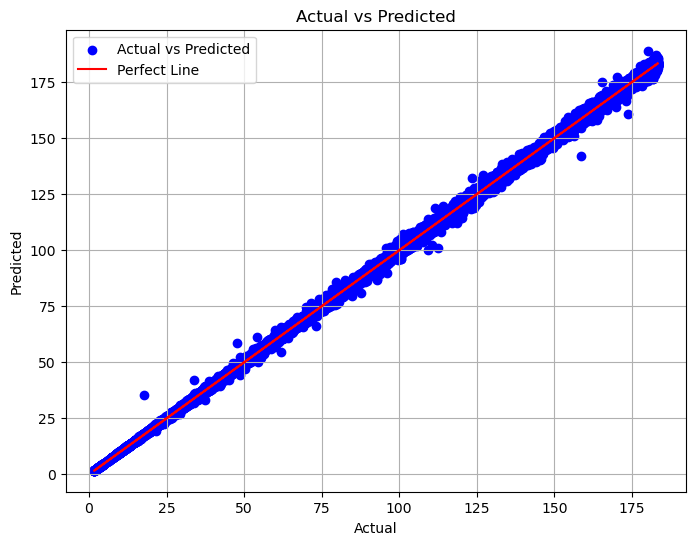

In [78]:
scatter_pred(retrain_LR)

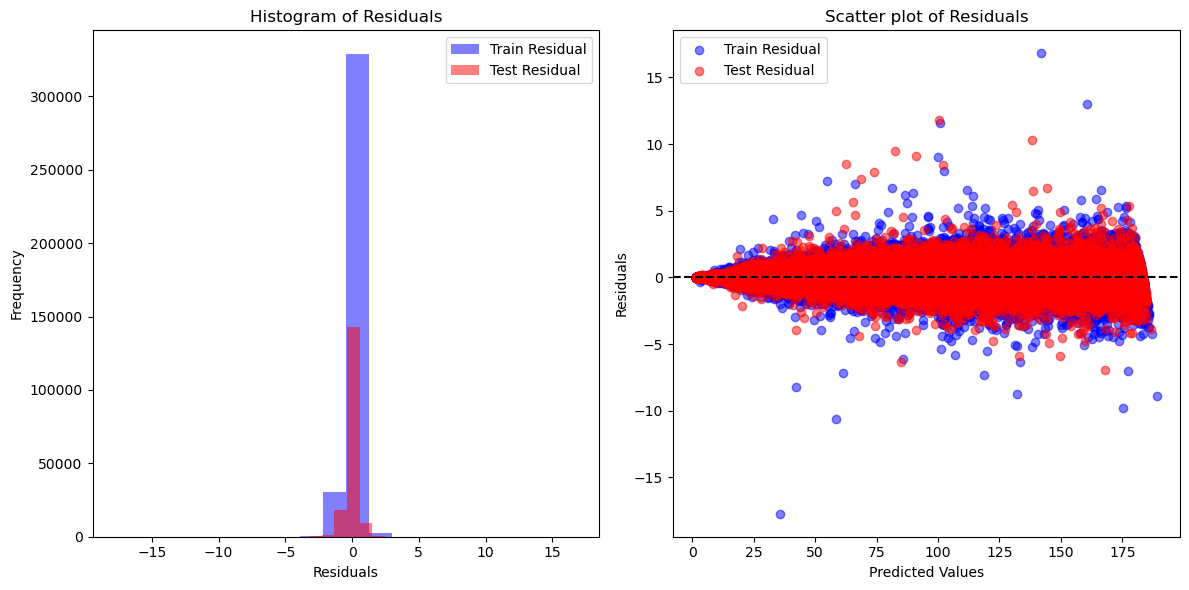

In [18]:

residual_train = retrain_LR.Actual - retrain_LR.Predicted
residual_test = retest_LR.Actual - retest_LR.Predicted
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(residual_train, bins=20, color='blue', alpha=0.5, label='Train Residual')
plt.hist(residual_test, bins=20, color='red', alpha=0.5, label='Test Residual')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(retrain_LR.Predicted, residual_train, color='blue', alpha=0.5, label='Train Residual')
plt.scatter(retest_LR.Predicted, residual_test, color='red', alpha=0.5, label='Test Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Scatter plot of Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()


**Test with the new data**

In [80]:
y_pred_val = model.predict(X_val)
results_val = pd.DataFrame({'Predicted': y_pred_val, 'Actual': y_val})
print("Predictions using the final model on validation data:")
display(results_val)


Predictions using the final model on validation data:


,Predicted,Actual
0,68.989950,68.64
1,53.131560,52.82
2,30.971644,31.11
3,21.464394,21.51
4,22.823176,22.82
...,...,...
40251,58.547699,58.74
40252,18.345836,18.49
40253,33.612730,33.47
40254,42.700368,42.59


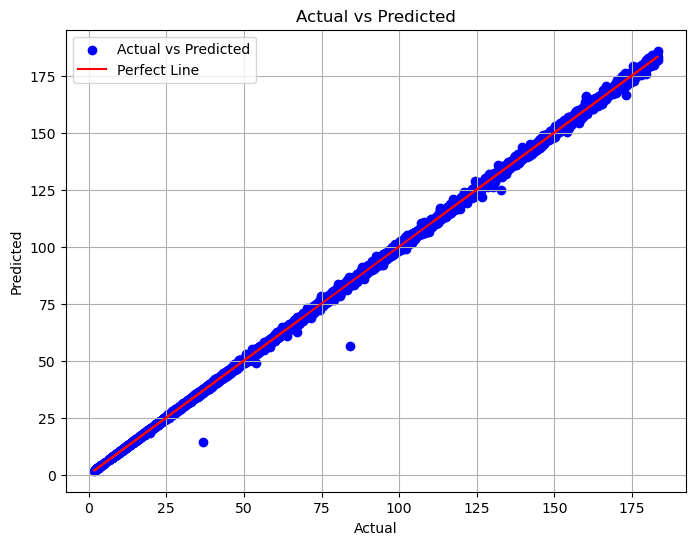

In [76]:

def scatter_pred(results_val):
    actual = results_val.Actual
    predicted = results_val.Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
    #plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Line')
    plt.plot(actual, actual, color='red', label='Perfect Line')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()
scatter_pred(results_val)

In [ ]:
residual_train = retrain_LR.Actual - retrain_LR.Predicted
residual_test = retest_LR.Actual - retest_LR.Predicted
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(residual_train, bins=20, color='blue', alpha=0.5, label='Train Residual')
plt.hist(residual_test, bins=20, color='red', alpha=0.5, label='Test Residual')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(retrain_LR.Predicted, residual_train, color='blue', alpha=0.5, label='Train Residual')
plt.scatter(retest_LR.Predicted, residual_test, color='red', alpha=0.5, label='Test Residual')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Scatter plot of Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()


**Test with new data**

In [75]:
#https://www.kaggle.com/code/parulpandey/getting-started-with-time-series-using-pandas/input?scriptVersionId=48515409

In [26]:
df_new = pd.read_csv("ADANIPORTS.csv")
df_new.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [27]:
data_new = df_new[['Date','Open','High','Low','Close','Volume']]
data_new.columns = df.columns[:-1]
data_new.head()

,date,open,high,low,close,volume
0,2007-11-27,770.00,1050.00,770.0,962.90,27294366
1,2007-11-28,984.00,990.00,874.0,893.90,4581338
2,2007-11-29,909.00,914.75,841.0,884.20,5124121
3,2007-11-30,890.00,958.00,890.0,921.55,4609762
4,2007-12-03,939.75,995.00,922.0,969.30,2977470


In [30]:
df_new = retime(data_new)
list_col = df_new.drop(columns=['year', 'month', 'day'])
list_col = list_col.columns
out_list = list_col
df_new= remove_outliers(df_new, out_list)
df_new.head()

,open,high,low,close,volume,year,month,day
38,700.0,810.0,660.05,735.55,546161,2008,1,22
42,835.0,835.0,783.20,820.80,467052,2008,1,28
49,803.0,824.9,780.00,807.50,193260,2008,2,6
50,825.0,830.0,792.00,796.25,212932,2008,2,7
51,810.0,830.0,765.15,784.05,285025,2008,2,8


In [167]:
X_new = df_result.drop(columns=['close'])  # Bỏ cột target_column
#scaler= RobustScaler()
#X_new_scaler = scaler.fit_transform(X_new)
#y_pred_new = model.predict(X_new_scaler)
y_pred_new = model.predict(X_new)
results_new = pd.DataFrame({'Predicted': y_pred_new, 'Actual': df_new['close']})
print("Predictions using the final model on new data:")
display(results_new)


D:\WorkplaceEnvironment\Anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: array length 247 does not match index length 3088

In [163]:
def nhap(data, model):
    df_new = data.copy()
    X_new = df_new.drop(columns=['close']) 
    y_pred_new = model.predict(X_new)
    results_new = pd.DataFrame({'Predicted': y_pred_new, 'Actual': df_new['close']})

    # Tính toán MSE, RMSE và R^2
    mse_new = mean_squared_error(results_new['Actual'], results_new['Predicted'])
    rmse_new = np.sqrt(mse_new)
    r2_new = r2_score(results_new['Actual'], results_new['Predicted'])
    
    # In kết quả
    print("Evaluation metrics on new data:")
    print("Mean Squared Error (MSE):", mse_new)
    print("Root Mean Squared Error (RMSE):", rmse_new)
    print("R-squared (R^2) Score:", r2_new)
    
    return results_new, mse_new, rmse_new, r2_new
nhap(df_result, model)

Evaluation metrics on new data:
Mean Squared Error (MSE): 66849430.975845315
Root Mean Squared Error (RMSE): 8176.1501316845515
R-squared (R^2) Score: -1842086.4680646046


D:\WorkplaceEnvironment\Anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


(         Predicted     Actual
 2251  -4827.052085  39.114286
 2252  -3384.727031  39.135714
 2253  -5126.314256  39.271429
 2254 -13416.154618  41.071429
 2255 -12510.322117  40.864286
 ...            ...        ...
 2494  -3490.082732  57.450000
 2495  -6119.891352  57.792857
 2496  -8402.598806  57.742857
 2497  -7975.081664  56.957143
 2498  -6384.040770  57.950000
 
 [247 rows x 2 columns],
 66849430.975845315,
 8176.1501316845515,
 -1842086.4680646046)

In [166]:
df_result

,open,high,low,close,volume,year,month,day
2251,38.542857,39.557143,38.142857,39.114286,2622173,2017,1,2
2252,39.314286,39.671429,38.864286,39.135714,2064823,2017,1,3
2253,39.307143,39.557143,38.885714,39.271429,2741205,2017,1,4
2254,39.471429,41.271429,39.357143,41.071429,5997054,2017,1,5
2255,41.257143,41.685714,40.714286,40.864286,5651466,2017,1,6
...,...,...,...,...,...,...,...,...
2494,57.571429,58.492857,57.028571,57.450000,2449944,2017,12,22
2495,57.678571,57.978571,57.171429,57.792857,3466595,2017,12,26
2496,57.992857,58.142857,57.242857,57.742857,4355090,2017,12,27
2497,57.742857,57.842857,56.792857,56.957143,4180605,2017,12,28


In [146]:
data.tail(2)

,open,high,low,close,volume,Name,year,month,day
619038,72.74,74.56,72.13,73.27,4924323,496,2018,2,6
619039,72.70,75.00,72.69,73.86,4534912,496,2018,2,7


In [147]:
data.head(2)

,open,high,low,close,volume,Name,year,month,day
0,15.07,15.12,14.63,14.75,8407500,1,2013,2,8
1,14.89,15.01,14.26,14.46,8882000,1,2013,2,11


In [145]:
df_new.tail(2)

,open,high,low,close,volume,year,month,day
3197,363.00,370.00,352.00,353.65,3863941,2020,10,28
3198,350.55,350.55,341.15,342.70,3346474,2020,10,29


In [161]:

df_first_four_columns = df_new.iloc[:, :4] / 7
df_result = pd.concat([df_first_four_columns, df_new.iloc[:, 4:]], axis=1)
df_result


,open,high,low,close,volume,year,month,day
38,100.000000,115.714286,94.292857,105.078571,546161,2008,1,22
42,119.285714,119.285714,111.885714,117.257143,467052,2008,1,28
49,114.714286,117.842857,111.428571,115.357143,193260,2008,2,6
50,117.857143,118.571429,113.142857,113.750000,212932,2008,2,7
51,115.714286,118.571429,109.307143,112.007143,285025,2008,2,8
...,...,...,...,...,...,...,...,...
3194,51.428571,52.714286,51.092857,52.050000,6357073,2020,10,23
3195,52.285714,53.414286,51.478571,51.957143,7541567,2020,10,26
3196,51.457143,52.314286,50.142857,52.057143,5869581,2020,10,27
3197,51.857143,52.857143,50.285714,50.521429,3863941,2020,10,28


In [157]:
X_new[X_new['year'] == 2017]

,open,high,low,volume,year,month,day
2251,5.995556,6.153333,5.933333,2622173,2017,1,2
2252,6.115556,6.171111,6.045556,2064823,2017,1,3
2253,6.114444,6.153333,6.048889,2741205,2017,1,4
2254,6.140000,6.420000,6.122222,5997054,2017,1,5
2255,6.417778,6.484444,6.333333,5651466,2017,1,6
...,...,...,...,...,...,...,...
2494,8.955556,9.098889,8.871111,2449944,2017,12,22
2495,8.972222,9.018889,8.893333,3466595,2017,12,26
2496,9.021111,9.044444,8.904444,4355090,2017,12,27
2497,8.982222,8.997778,8.834444,4180605,2017,12,28


In [168]:
X_2017= df_new[df_new['year'] == 2017]
df_first_four_columns = X_2017.iloc[:, :4] / 7
df_result = pd.concat([df_first_four_columns, X_2017.iloc[:, 4:]], axis=1)
df_result


,open,high,low,close,volume,year,month,day
2251,38.542857,39.557143,38.142857,39.114286,2622173,2017,1,2
2252,39.314286,39.671429,38.864286,39.135714,2064823,2017,1,3
2253,39.307143,39.557143,38.885714,39.271429,2741205,2017,1,4
2254,39.471429,41.271429,39.357143,41.071429,5997054,2017,1,5
2255,41.257143,41.685714,40.714286,40.864286,5651466,2017,1,6
...,...,...,...,...,...,...,...,...
2494,57.571429,58.492857,57.028571,57.450000,2449944,2017,12,22
2495,57.678571,57.978571,57.171429,57.792857,3466595,2017,12,26
2496,57.992857,58.142857,57.242857,57.742857,4355090,2017,12,27
2497,57.742857,57.842857,56.792857,56.957143,4180605,2017,12,28


In [174]:
X_new = df_result.drop(columns=['close'])  # Bỏ cột target_column

y_pred_new = model.predict(X_new)
results_new = pd.DataFrame({'Predicted': y_pred_new, 'Actual': df_result['close']})
print("Predictions using the final model on new data:")
display(results_new)


Predictions using the final model on new data:


D:\WorkplaceEnvironment\Anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


,Predicted,Actual
2251,-4827.052085,39.114286
2252,-3384.727031,39.135714
2253,-5126.314256,39.271429
2254,-13416.154618,41.071429
2255,-12510.322117,40.864286
...,...,...
2494,-3490.082732,57.450000
2495,-6119.891352,57.792857
2496,-8402.598806,57.742857
2497,-7975.081664,56.957143


In [160]:
data[data['year'] == 2017]

,open,high,low,close,volume,Name,year,month,day
982,47.28,47.340,46.135,46.30,6737752,1,2017,1,3
983,46.63,47.435,46.350,46.70,5859604,1,2017,1,4
984,46.52,46.930,45.610,45.89,6825316,1,2017,1,5
985,45.85,46.720,45.470,46.21,7260197,1,2017,1,6
986,46.01,47.340,45.780,47.08,4739142,1,2017,1,9
...,...,...,...,...,...,...,...,...,...
619009,72.30,72.370,71.790,71.99,1345683,496,2017,12,22
619010,72.40,72.550,71.900,72.34,792134,496,2017,12,26
619011,72.59,72.690,72.250,72.45,1159771,496,2017,12,27
619012,72.49,72.600,72.140,72.39,710499,496,2017,12,28
